### In this notebook we will briefly talk about what Neural Network is and then apply it to our data (GDP per capita) and then we will evaluate our model

NOTE: We will both tackle CLASSIFICATION and REGRESSION problems

CLASSIFICATION: ML problem in which the output variable is a category, in discrete numerical values

REGRESSION: ML problem in which the model predicted output is a continuous numerical value

In [2]:
# Import Libraries/Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, accuracy_score
from sklearn.metrics import confusion_matrix

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import losses

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Next, we import the functions from our original data exploration notebook. These will be used to get our data clean enough to be fed to our models.

In [3]:
# FUNCTIONS FROM NOTEBOOK 1

def merge_data(country_data, height_data):
  height_data = height_data.rename(columns={"Country Name" : "Country"})
  country_data['Country'] = country_data.apply(lambda row : row.astype(str)['Country'][:-1], axis=1)
  old_names = ['Antigua & Barbuda', 'Bahamas, The', 'Bosnia & Herzegovina', 'Central African Rep.', 'Congo, Dem. Rep.', 'Swaziland', 'Gambia, The', 'Cote d\'Ivoire',
             'Micronesia, Fed. St.', 'Burma', 'Korea, North', 'Macedonia', 'Congo, Repub. of the', 'Saint Kitts & Nevis', 'Sao Tome & Principe',
             'Korea, South', 'East Timor', 'Trinidad & Tobago']

  new_names = ['Antigua and Barbuda', 'Bahamas', 'Bosnia and Herzegovina', 'Central African Republic', 'DR Congo', 'Eswatini', 'Gambia', 'Ivory Coast', 'Micronesia',
              'Myanmar', 'North Korea', 'North Macedonia', 'Republic of the Congo', 'Saint Kitts and Nevis', 'Sao Tome and Principe', 'South Korea',
              'Timor-Leste', 'Trinidad and Tobago']

  for i in range(len(old_names)):
    country_data['Country'].replace({old_names[i]: new_names[i]}, inplace=True)
  
  merged_df = pd.merge(country_data, height_data, on=['Country'])
  return merged_df

# FUNCTIONS FROM NOTEBOOK 2

def rename_regions(row):
  if row['Region'] == 'ASIA (EX. NEAR EAST)':
    region = 'ASIA'
  elif row['Region'] == 'NEAR EAST':
    region = 'MIDDLE EAST'
  elif row['Region'] == 'C.W. OF IND. STATES':
    region = "C.W.I. STATES"
  else:
    region = row['Region']
  return region

def format_and_clean_data(merged_data):
  merged_data['Region'] = merged_data.apply(lambda row : row.astype(str)['Region'].strip(), axis=1)
  merged_data['Region'] = merged_data.apply(lambda row : rename_regions(row), axis=1)

  for col in merged_data.columns.values:
    if merged_data[col].isnull().sum() == 0:
        continue
    if col == 'Climate':
        guess_values = merged_data.groupby('Region')['Climate'].apply(lambda x: x.mode().max())
    else:
        guess_values = merged_data.groupby('Region')[col].median()
    for region in merged_data['Region'].unique():
        merged_data[col].loc[(merged_data[col].isnull())&(merged_data['Region']==region)] = guess_values[region]
  return merged_data

# FUNCTIONS FROM NOTEBOOK 3

def get_gdp_dataset(merged_data):
  merged_data = merged_data.drop(['Male Height in Cm', 'Female Height in Cm'], axis=1)
  merged_data['Average Height in Ft'] = merged_data['Female Height in Ft'] / 2 + merged_data['Male Height in Ft'] / 2
  merged_data = merged_data.drop(['Male Height in Ft', 'Female Height in Ft'], axis=1)

  GDP_features = ['GDP ($ per capita)', 'Infant mortality (per 1000 births)', 'Net migration', 'Pop. Density (per sq. mi.)',
                'Literacy (%)', 'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry', 'Service']
  gdp_data = merged_data[GDP_features]
  
  return gdp_data

def get_height_dataset(merged_data):
  merged_data = merged_data.drop(['Male Height in Cm', 'Female Height in Cm'], axis=1)
  merged_data['Average Height in Ft'] = merged_data['Female Height in Ft'] / 2 + merged_data['Male Height in Ft'] / 2
  merged_data = merged_data.drop(['Male Height in Ft', 'Female Height in Ft'], axis=1)

  height_features = ['Average Height in Ft', 'Agriculture', 'Service', 'Phones (per 1000)', 'GDP ($ per capita)', 'Literacy (%)']
  avg_height_data = merged_data[height_features]

  return avg_height_data

Let's get to data preprocessing! First we will use pandas (pd) to read our csv files. Then, we can manipulate the functions above to clean out data.

In [4]:
height_data = pd.read_csv('../content/sample_data/Height of Male and Female by Country 2022.csv')
country_data = pd.read_csv('../content/sample_data/countries of the world.csv', decimal=',')

merged_data = merge_data(country_data, height_data)
merged_data = format_and_clean_data(merged_data)
gdp_data = get_gdp_dataset(merged_data)
avg_height_data = get_height_dataset(merged_data)

gdp_data.head()

,GDP ($ per capita),Infant mortality (per 1000 births),Net migration,Pop. Density (per sq. mi.),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
0,700.0,163.07,23.06,48.0,36.0,3.2,46.60,0.380,0.240,0.380
1,4500.0,21.52,-4.93,124.6,86.5,71.2,15.11,0.232,0.188,0.579
2,6000.0,31.00,-0.39,13.8,70.0,78.1,17.14,0.101,0.600,0.298
3,8000.0,9.27,-20.71,290.4,97.0,259.5,22.46,0.151,0.190,0.620
4,19000.0,4.05,6.60,152.1,100.0,497.2,8.71,0.021,0.274,0.707


In [ ]:
avg_height_data.head()

,Average Height in Ft,Agriculture,Service,Phones (per 1000),GDP ($ per capita),Literacy (%)
0,5.325,0.380,0.380,3.2,700.0,36.0
1,5.515,0.232,0.579,71.2,4500.0,86.5
2,5.535,0.101,0.298,78.1,6000.0,70.0
3,5.655,0.151,0.620,259.5,8000.0,97.0
4,5.650,0.021,0.707,497.2,19000.0,100.0


Features: the input data/variables our ML model takes in to make prediction

Target: the output data/variables our ML model aims to predict

Whenever we train a model, its important to split it up into a training data set and a test data set. The main reason we do this is to make sure that the model learns the patterns in the data instead of just memorizing the entire dataset. Basically, we want to make sure that the model doesn't overfit on the data. Its like when you get a review for a test, you are given questions that are similar to the test but not the exact same question to make sure you can't just memorize the questions on the review.

### Overfitting: happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data

For this example, 70% of our data will consist of training data, while the rest of 30% will be testing data

train_X and train_Y will be the training feature, target respectively. test_X and test_Y will be the testing feature, target respectively.

We're also shuffling our data so that every data entry has an equal chance of being selected for testing data, incase certain groups of data were concentrated

In [ ]:
train, test = train_test_split(gdp_data, test_size=0.3, shuffle=True)
# The Different class of inputs
# In this scenario, our model can learn from 9 features
training_features = ['Infant mortality (per 1000 births)',
                     'Net migration', 'Pop. Density (per sq. mi.)',
                     'Literacy (%)', 'Phones (per 1000)', 'Birthrate',
                     'Agriculture', 'Industry', 'Service']

# The target we would like our model to predict
# In this scenario, our model will only predict one target
target = 'GDP ($ per capita)'
train_X = train[training_features] # 136 instances of data, each with 9 features
train_Y = train[target] # 136 instances of data, each with 1 target to predict
test_X = test[training_features] # 59 instances of data, each with 9 features
test_Y = test[target] # 59 instances of data, each with 1 target to predict

In [ ]:
# This tells us that we have 136 sets of training data and have 9 features each
print(train_X.shape) # 136 rows and 9 columns
train_X

(136, 9)


,Infant mortality (per 1000 births),Net migration,Pop. Density (per sq. mi.),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
131,3.70,1.74,14.2,100.0,461.7,11.46,0.021,0.415,0.564
127,5.85,4.05,15.2,99.0,441.7,13.76,0.043,0.273,0.684
128,29.11,-1.22,43.0,67.5,39.7,24.51,0.165,0.275,0.560
150,27.71,-11.70,60.1,99.7,75.2,16.43,0.114,0.584,0.302
120,53.79,0.00,1.8,97.8,55.1,21.59,0.206,0.214,0.580
...,...,...,...,...,...,...,...,...,...
28,97.57,0.00,50.7,26.6,7.0,45.62,0.322,0.196,0.482
149,14.78,-7.64,303.0,96.0,190.9,16.18,0.100,0.260,0.640
175,66.61,0.00,97.7,60.9,10.6,37.01,0.395,0.204,0.401
169,4.39,4.05,182.2,99.0,680.9,9.71,0.015,0.340,0.645


In the next block, we create our Neural Network model using Tensorflow. Tensorflow makes it super easy to set up the model and train it on the data, simply create the model and how may neurons there should be at each layer, then give it the training data and it will start to learn. After the model is trained, we feed it the test data and compare its answers to the actual answers. This allows us to evaluate how good of a model it is. For our first metric we are using mean absolute error. This is how far from the correct answer the model is on average. Then we use the .describe() function to see what the standard diviation of the dataset to get a better idea of how good or bad the mean average error is in relation to the actual dataset.

In Generl Terms: A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates.

If you would like to learn more about Neural Networks, watch this series: https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

Loss Function: a function that measures how far an estimated value is from its true value. Learn more here: https://www.youtube.com/watch?v=-qT8fJTP3Ks

Optimizer: a function or an algorithm that modifies the attributes of the neural network, such as weights and learning rate. Learn more here: https://www.youtube.com/watch?v=JhQqquVeCE0

Activation Function: a function that defines how the weighted sum of the input is transformed into an output from a node or nodes in a layer of the network. Learn more here: https://www.youtube.com/watch?v=aJToUocPLg4

In [12]:
### NOTE!!! Let's first tackle an REGRESSION problem
#Notice how we have 9 as the initial input dimension (line7) for this neural network and 1 final output layer (line15).
#This is because our model has 9 features to learn from and 1 specific target the model is trying to predict.
model = Sequential()

# The Input Layer :
model.add(Dense(128, kernel_initializer='normal',input_dim = 9, activation='relu'))

# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


Let's train our model, epochs meant how many rounds of training we want the model to perform, batch_size is the number of training examples in one forward/backward pass. Generally, the larger your batch_size the faster your model computes due to parallelization and the model utilizes more ram. When the model returns an error stating how it ran out of ram, tune down your batch_size. However, in this scenario, our model isn't computationally expensive enough for this to happen, so you can mess around with the batch_size.

In [13]:
model.fit(train_X, train_Y, epochs=15, batch_size=32)

Epoch 1/15
5/5 [==============================] - 1s 2ms/step - loss: 8558.3096 - mean_absolute_error: 8558.3096
Epoch 2/15
5/5 [==============================] - 0s 2ms/step - loss: 8523.4512 - mean_absolute_error: 8523.4512
Epoch 3/15
5/5 [==============================] - 0s 2ms/step - loss: 8395.5605 - mean_absolute_error: 8395.5605
Epoch 4/15
5/5 [==============================] - 0s 3ms/step - loss: 7967.8105 - mean_absolute_error: 7967.8105
Epoch 5/15
5/5 [==============================] - 0s 3ms/step - loss: 7059.8120 - mean_absolute_error: 7059.8120
Epoch 6/15
5/5 [==============================] - 0s 3ms/step - loss: 5936.9824 - mean_absolute_error: 5936.9824
Epoch 7/15
5/5 [==============================] - 0s 2ms/step - loss: 5236.4727 - mean_absolute_error: 5236.4727
Epoch 8/15
5/5 [==============================] - 0s 2ms/step - loss: 4791.9531 - mean_absolute_error: 4791.9531
Epoch 9/15
5/5 [==============================] - 0s 3ms/step - loss: 4115.6768 - mean_absolute_

Pay careful attention to the dimensions/shape of your input and output!

test_x.shape is (59,9), meaning there're 59 sets of sample data each with 9 different features. So... predictions.shape is (59, 1), since our model is predicting for 59 sets of data and it only has one target to predict.

In [14]:
predictions = model.predict(test_X)
print(f"Dimension of input: {test_X.shape} (test_X)")
print(f"Dimension of output: {predictions.shape} (predictions)")

Dimension of input: (59, 9) (test_X)
Dimension of output: (59, 1) (predictions)


For this REGRESSION Problem, we will evaluate our model with the metric MAE(Mean Absolute Error)

MAE: the magnitude of difference between the prediction of an observation and the true value of that observation. Calculation: Find all of your absolute errors: absolute value of -> (Actual Value — Predicted Value). Add them all up. Divide by the number of errors.

In [15]:
print(mean_absolute_error(predictions, test_Y))

3320.19664596299


We will also try to create a (classification problem) discrete prediction with our Neural Network model. To achieve this, we break up the different GDPs into 5 equally sized buckets. These represent a label, either very poor, poor, average, wealthy or very wealthy

In [16]:
gdp_data['GDP ($ per capita)'] = pd.qcut(gdp_data['GDP ($ per capita)'], 5, labels=False)
print(f"Number of labels: {gdp_data['GDP ($ per capita)'].nunique()}")
gdp_data.describe()

Number of labels: 5


,GDP ($ per capita),Infant mortality (per 1000 births),Net migration,Pop. Density (per sq. mi.),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
count,195.000000,195.000000,195.000000,195.000000,195.00000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,2.000000,38.936846,-0.437077,201.308205,82.29641,198.387179,22.889744,0.158349,0.293564,0.547195
std,1.417854,36.382098,4.466701,667.646406,20.01014,199.670583,11.359249,0.149453,0.135160,0.154904
min,0.000000,2.290000,-20.990000,0.000000,17.60000,0.200000,7.290000,0.000000,0.040000,0.062000
25%,1.000000,10.020000,-1.315000,26.800000,69.95000,27.100000,12.835000,0.039000,0.203500,0.425500
50%,2.000000,24.310000,0.000000,69.800000,92.30000,131.800000,20.690000,0.112000,0.275000,0.560000
75%,3.000000,62.550000,0.305000,151.000000,98.00000,305.550000,30.815000,0.231000,0.349000,0.665000
max,4.000000,191.190000,23.060000,6482.200000,100.00000,898.000000,50.730000,0.769000,0.906000,0.906000


We will have to retrain the model with the new labels. In the next block we reset the data but with the new labels and then feed it into our Neural Network model again.

In [17]:
train, test = train_test_split(gdp_data, test_size=0.3, shuffle=True)
training_features = ['Infant mortality (per 1000 births)',
       'Net migration', 'Pop. Density (per sq. mi.)', 'Literacy (%)',
       'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry',
       'Service']
target = 'GDP ($ per capita)'
train_X = train[training_features] # 136 instances of data, each with 9 features
train_Y = train[target] # 136 instances of data, each with 5 different possible target to predict
test_X = test[training_features] # 59 instances of data, each with 9 features
test_Y = test[target] # 59 instances of data, each with 5 different possible target to predict

In [20]:
train_X.shape

(136, 9)

In [29]:
### NOTE!!! Let's first tackle an CLASSIFICATION problem
# -> Notice how we have still have 9 as the initial input dimension (line7) for this neural network
# -> However, our output dimension will be 5(line16) as opposed to 1 in the prior scenario
# -> This is because our model has 9 features to learn from and 5 targets the model is trying to predict.
model = Sequential()

# The Input Layer :
model.add(Dense(128, kernel_initializer='normal',input_dim = 9, activation='relu'))

# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(5, kernel_initializer='normal'))

# Compile the network :
model.compile(optimizer='adam',
              loss=losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

adj_train_Y = []
for row in train_Y:
  new_row = [0, 0, 0, 0, 0]
  new_row[row] = 1
  adj_train_Y.append(new_row)
adj_train_Y = np.array(adj_train_Y)
model.fit(train_X, adj_train_Y, epochs=15, batch_size=32)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               1280      
                                                                 
 dense_21 (Dense)            (None, 256)               33024     
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 256)               65792     
                                                                 
 dense_24 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 167,173
Trainable params: 167,173
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
5/5 [==============================] 

test_x.shape is (59,9), meaning there're 59 sets of sample data each with 9 different features. So... predictions.shape is (59, 5), since our model is predicting for 59 sets of data and it has 5 targets to predict.

In [42]:
predictions = model.predict(test_X)
print(f"Dimension of input: {test_X.shape} (test_X)")
print(f"Dimension of output: {predictions.shape} (predictions)")

Dimension of input: (59, 9) (test_X)
Dimension of output: (59, 5) (predictions)


Let's take a look at one of the model's prediction and notice how they aren't perfect integers

The Neural Network outputs probabilities for the classes of target, so we treat the max number in the list as prediction

In [41]:
sample_index = 0
# raw model prediction
print(predictions[sample_index])
# maxed out model prediction with Numpy
largest_index = np.where(predictions[sample_index] == max(predictions[sample_index]))
print(predictions[sample_index][largest_index])
# you can see the largest number is located at index 2, so target 3 is our model prediction

[-0.35729855  1.9239146   2.1203842  -0.22724673 -2.2875826 ]
[2.1203842]


Because this is a discrete model, we can create a confusion matrix to see where the model is going wrong and see what it is misclassifying. This is a great way to visualize the evaluation metrics. For this confusion matrix, we use sklearn.metrics.

### A Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model.

Let say row 1 and column 1 represent the target class "Poor". Then, cf_matrix[1][1] tells that 4 predictions were made accurately for the target class "Poor"

Let say row 0 represent the target class "Very Poor" and column 1 represent the target class "Poor". Then, cf_matrix[0][1] tells that 8 predictions were made incurrately where: the model predicted 8 target classes of "Poor", but they were actually supposed to be the target class "Very Poor"

In [64]:
predictions = model.predict(test_X)
adj_predictions = []

for prediction in predictions:
  largest_index = np.where(prediction == max(prediction))
  adj_predictions.append(largest_index[0])
adj_predictions = np.array(adj_predictions)
cf_matrix = confusion_matrix(np.array(test_Y), adj_predictions)
cf_matrix

array([[8, 0, 1, 0, 0],
       [0, 4, 6, 1, 0],
       [0, 3, 6, 3, 1],
       [0, 0, 5, 7, 3],
       [0, 0, 0, 2, 9]], dtype=int64)

With our confusion matrix set up, we will now set up the heatmap to show it off in a more visually appealing way. We will need to create the title, x-axis label, y-axis label, and the different labels for the different sections.

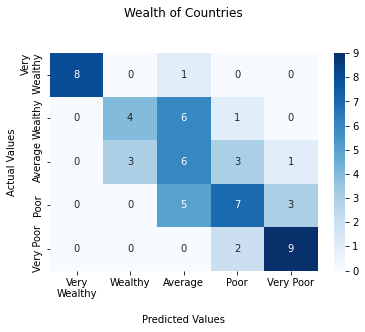

In [65]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Wealth of Countries\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['Very\nWealthy','Wealthy','Average','Poor','Very Poor'])
ax.yaxis.set_ticklabels(['Very\n Wealthy','Wealthy','Average','Poor','Very Poor'])

plt.show()

For the next confusion matrix, I wanted to see the % of each answer within a row.

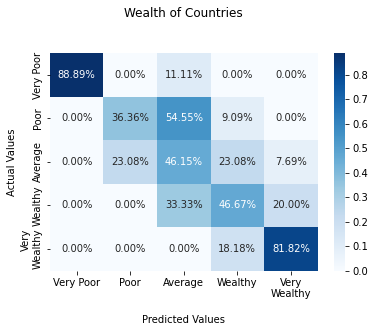

In [66]:
cf_matrix = confusion_matrix(np.array(test_Y), adj_predictions)
percent_matrix = []
for i in range(len(cf_matrix)):
  percent_matrix.append(cf_matrix[i]/sum(cf_matrix[i]))

ax = sns.heatmap(percent_matrix, annot=True, cmap='Blues', fmt='.2%')

ax.set_title('Wealth of Countries\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['Very Poor','Poor','Average','Wealthy','Very\nWealthy'])
ax.yaxis.set_ticklabels(['Very Poor','Poor','Average','Wealthy','Very\nWealthy'])

plt.show()

Finally, we will print out the raw accuacy of our model, meaning how often it labeled the country correctly.

Accuracy Score: the ratio of number of correct predictions to the total number of input samples. Calculation: (number of labels accurately predicted) / (total instance of labels)

Note: 100% is the best accuracy there is, but be suspicious because this might be a result of overfitting

### Overfitting: happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data

In [67]:
accuracy_score(np.array(test_Y), adj_predictions)

0.576271186440678

#### Why is our model's accuracy so low? Possibilities that can explain this:
#### 	1) The input data and output target have a very low correlation.
#### 	2) There isn't enough data for the model to learn anything...
#### 	3) The model is too weak and is unable to pick up correlations from the data.